In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from scipy.stats import mode

In [50]:
class LogisticRegression:
    def __init__(self, learning_rate=0.1, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def y_hat(self, X, weights):
        return self.sigmoid(np.dot(X,weights))
    
    def dw(self, X, y, weights):
        y_hat = self.y_hat(X, weights)
        return np.dot(X.T, (y_hat - y)) / y.size
    
    def fit(self, X, y):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.weights = np.zeros(X.shape[1], dtype=np.float64)
        for i in range(self.iterations):
            self.weights -= self.learning_rate * self.dw(X, y, self.weights)
    
    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X] # For bias
        y_pred = self.sigmoid(np.dot(X, self.weights))
        return np.where(y_pred >= 0.5, 1, 0)

In [51]:
def baggingLR(X, y, learning_rate=0.5, iterations=1000, n_models=9):
    models = []
    for i in range(n_models):
        model = LogisticRegression(learning_rate, iterations)
        indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
        X_sample = X[indices]
        y_sample = y[indices]
        model.fit(X_sample, y_sample)
        models.append(model)
    return models

In [52]:
def stackingLR(base_models, X_train, y_train, learning_rate=0.5, iterations=1000):
    n = X_train.shape[1]
    base_predictions = np.zeros((X_train.shape[0], n+len(base_models)))
    # base_predictions = np.zeros((X_train.shape[0], len(base_models)))
    for i, model in enumerate(base_models):
        base_predictions[:,i+n] = model.predict(X_train)
        # base_predictions[:,i] = model.predict(X_train)
        
    # Train meta classifier
    meta_model = LogisticRegression(learning_rate=learning_rate, iterations=iterations)
    meta_model.fit(base_predictions, y_train)
    return meta_model

In [53]:
def basePredictions(base_models, X):
    n = X.shape[1]
    base_predictions = np.zeros((X.shape[0], n+len(base_models)))
    # base_predictions = np.zeros((X.shape[0], len(base_models)))
    for i, model in enumerate(base_models):
        base_predictions[:,i+n] = model.predict(X)
        # base_predictions[:,i] = model.predict(X)
    return base_predictions

In [54]:
from scipy.stats import mode

def majority_voting(models, X_test):
    predictions = np.array([model.predict(X_test) for model in models])
    final_predictions, _ = mode(predictions, axis=0)
    return final_predictions.flatten()

In [55]:
def performanceMetrics(y_true, y_pred):
    p = np.sum(y_true == 1)
    n = np.sum(y_true == 0)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    accuracy = (tp + tn) / (p + n) if p + n != 0 else 0
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    specificity = tn / (tn + fp) if tn + fp != 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    
    auroc = roc_auc_score(y_true, y_pred) if p > 0 and n > 0 else 0
    precision_arr, recall_arr, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_arr, precision_arr) if p > 0 and n > 0 else 0
    
    report = {
        'Confusion Matrix': confusion_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'AUROC': auroc,
        'AUPRC': auprc
    }
    
    return report


In [56]:
def LRStar(models, X_test, y_test):
    accuracy_list = []
    precision_list = []
    recall_list = []
    specificity_list = []
    f1_list = []
    auroc_list = []
    auprc_list = []

    for model in models:
        y_pred = model.predict(X_test)
        report = performanceMetrics(y_test, y_pred)

        accuracy_list.append(report['Accuracy'])
        precision_list.append(report['Precision'])
        recall_list.append(report['Sensitivity'])
        specificity_list.append(report['Specificity'])
        f1_list.append(report['F1 Score'])
        auroc_list.append(report['AUROC'])
        auprc_list.append(report['AUPRC'])


    report = {
        'Accuracy': f"{np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}",
        'Precision': f"{np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}",
        'Sensitivity': f"{np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}",
        'Specificity': f"{np.mean(specificity_list):.4f} ± {np.std(specificity_list):.4f}",
        'F1 Score': f"{np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}",
        'AUROC': f"{np.mean(auroc_list):.4f} ± {np.std(auroc_list):.4f}",
        'AUPRC': f"{np.mean(auprc_list):.4f} ± {np.std(auprc_list):.4f}"
    }

    return report

In [57]:
def GenDataForPlot(models, X_test, y_test):
    accuracy_list = []
    precision_list = []
    recall_list = []
    specifity_list = []
    f1_list = []
    auroc_list = []
    auprc_list = []

    for model in models:
        y_pred = model.predict(X_test)
        report = performanceMetrics(y_test, y_pred)

        accuracy_list.append(report['Accuracy'])
        precision_list.append(report['Precision'])
        recall_list.append(report['Sensitivity'])
        specifity_list.append(report['Specificity'])
        f1_list.append(report['F1 Score'])
        auroc_list.append(report['AUROC'])
        auprc_list.append(report['AUPRC'])

    return accuracy_list, precision_list, recall_list,specifity_list, f1_list, auroc_list, auprc_list

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_violin_plots(models, X_test, y_test):
    accuracy_list, precision_list, recall_list,specifity_list, f1_list, auroc_list, auprc_list = GenDataForPlot(models, X_test, y_test)
    
    metrics = {
        'Accuracy': accuracy_list,
        'Precision': precision_list,
        'Sensitivity': recall_list,
        'Specificity': specifity_list,
        'F1 Score': f1_list,
        'AUROC': auroc_list,
        'AUPRC': auprc_list
    }

    # Define the figure and subplots
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Violin Plots for Different Metrics Across 9 Models')

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Loop through the metrics and create a subplot for each one
    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        # Create a violin plot
        sns.violinplot(data=metric_values, ax=axes[i])
        axes[i].set_title(f'{metric_name} Distribution')
        axes[i].set_xlabel('Models')
        axes[i].set_ylabel(metric_name)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [59]:
def preprocess_telco_data():
    df = pd.read_csv('datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(inplace=True)

    X = df.drop(columns=['Churn', 'customerID'])
    y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    categorical_cols = X.select_dtypes(include=['object']).columns
    numerical_cols = X.select_dtypes(exclude=['object']).columns

    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    train_xx, test_xx, train_yy, test_yy = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, val_x, train_y, val_y = train_test_split(train_xx, train_yy, test_size=0.2, random_state=42)

    return train_x, train_y, val_x, val_y, test_xx, test_yy

In [60]:
from sklearn.preprocessing import LabelEncoder
def preprocess_adult_data():
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country', 'income'
    ]

    train_df = pd.read_csv('datasets/adult/adult.data', header=None, names=column_names, na_values=' ?', skipinitialspace=True)
    test_df = pd.read_csv('datasets/adult/adult.test', header=None, names=column_names, na_values=' ?', skipinitialspace=True, skiprows=1)

    #duplicate value removal
    train_df = train_df.drop_duplicates()
    test_df = test_df.drop_duplicates()

    # missing handling
    train_df = train_df.dropna(subset=["income"])
    test_df = test_df.dropna(subset=["income"])

    train_df.loc[:, :] = train_df.fillna(train_df.mode().iloc[0])
    test_df.loc[:, :] = test_df.fillna(test_df.mode().iloc[0])
    

    X_train = train_df.drop(columns=['income'])
    y_train = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
    X_test = test_df.drop(columns=['income'])
    y_test = test_df['income'].apply(lambda x: 1 if x == '>50K.' else 0)

    categorical_cols = X_train.select_dtypes(include=['object']).columns
    numerical_cols = X_train.select_dtypes(exclude=['object']).columns

    X_train = pd.get_dummies(X_train, columns=categorical_cols)
    X_test = pd.get_dummies(X_test, columns=categorical_cols)
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Add missing columns to the test data
    missing_cols = set(train_x.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0

    # Ensure the order of column in the test set is in the same order than in train set
    X_test = X_test[train_x.columns]

    return train_x, train_y, val_x, val_y, X_test, y_test


In [61]:
def preprocess_creditcard_data():
    df = pd.read_csv('datasets/creditcard.csv')

    # df = df.drop_duplicates()

    # Scale down dataset for faster training
    positive_samples = df[df['Class'] == 1]
    negative_samples = df[df['Class'] == 0]
    negative_samples = negative_samples.drop_duplicates()

    negative_samples_subset = negative_samples.sample(n=20000, random_state=42)

    balanced_subset = pd.concat([positive_samples, negative_samples_subset], axis=0)
    df = balanced_subset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = df.drop(columns=['Class'])
    y = df['Class']

    columns = X.columns
    scaler = StandardScaler()
    X[columns] = scaler.fit_transform(X[columns])

    train_xx, test_xx, train_yy, test_yy = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, val_x, train_y, val_y = train_test_split(train_xx, train_yy, test_size=0.2, random_state=42)

    return train_x, train_y, val_x, val_y, test_xx, test_yy

In [62]:
from sklearn.feature_selection import mutual_info_classif
def feature_selection_using_information_gain(X_train, y_train, top_features=20):
    
    top_features = min(top_features, len(X_train.columns))
    
    discrete_features_mask = X_train.dtypes == 'object'
    
    info_gain = mutual_info_classif(X_train, y_train, discrete_features=discrete_features_mask)

    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Information Gain': info_gain
    })

    feature_scores = feature_scores.sort_values(by='Information Gain', ascending=False)

    top_features_list = feature_scores['Feature'].head(top_features).tolist()

    return X_train[top_features_list], top_features_list


In [63]:
def features_selection_using_correlation(X_train, y_train, top_features=20):
    top_features = min(top_features, len(X_train.columns))
    X_train['target'] = y_train
    corr_matrix = X_train.corr()

    corr_with_target = corr_matrix['target'].abs().sort_values(ascending=False)
    top_features_list = corr_with_target[1:top_features+1].index.tolist()

    return X_train[top_features_list], top_features_list

In [64]:
def experiment(dataset,exp_no,withTopFeatures=False, top_features=20, withCorrelation=False):
    if dataset == 1:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_telco_data()
    elif dataset == 2:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_adult_data()
    elif dataset == 3:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_creditcard_data()
    
    if withTopFeatures:
        if withCorrelation:
            train_x, top_features_list = features_selection_using_correlation(train_x, train_y, top_features)
        else: # With Information Gain
            train_x, top_features_list = feature_selection_using_information_gain(train_x, train_y, top_features)

        val_x = val_x[top_features_list]
        test_x = test_x[top_features_list]
    
    train_x = train_x.to_numpy(dtype=np.float64)
    train_y = train_y.to_numpy(dtype=np.float64)
    val_x = val_x.to_numpy(dtype=np.float64)
    val_y = val_y.to_numpy(dtype=np.float64)
    test_x = test_x.to_numpy(dtype=np.float64)
    test_y = test_y.to_numpy(dtype=np.float64)

    # Merge train and validation sets for experiments 1 and 2
    if exp_no in [1, 2]:
        train_x = np.concatenate([train_x, val_x], axis=0)
        train_y = np.concatenate([train_y, val_y], axis=0)

    base_models = baggingLR(train_x, train_y)
    if exp_no == 1:
        report = LRStar(base_models, test_x, test_y)
    elif exp_no == 2:
        y_pred = majority_voting(base_models, test_x)
        report = performanceMetrics(test_y, y_pred)
    else:
        meta_model = stackingLR(base_models, val_x, val_y)
        y_pred = meta_model.predict(basePredictions(base_models, test_x))
        report = performanceMetrics(test_y, y_pred)


    return report

In [65]:
def violin_plot(dataset,withTopFeatures=False, top_features=20, withCorrelation=False):
    if dataset == 1:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_telco_data()
    elif dataset == 2:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_adult_data()
    elif dataset == 3:
        train_x, train_y, val_x, val_y, test_x, test_y = preprocess_creditcard_data()
    
    if withTopFeatures:
        if withCorrelation:
            train_x, top_features_list = features_selection_using_correlation(train_x, train_y, top_features)
        else: # With Information Gain
            train_x, top_features_list = feature_selection_using_information_gain(train_x, train_y, top_features)

        val_x = val_x[top_features_list]
        test_x = test_x[top_features_list]
    
    train_x = train_x.to_numpy(dtype=np.float64)
    train_y = train_y.to_numpy(dtype=np.float64)
    val_x = val_x.to_numpy(dtype=np.float64)
    val_y = val_y.to_numpy(dtype=np.float64)
    test_x = test_x.to_numpy(dtype=np.float64)
    test_y = test_y.to_numpy(dtype=np.float64)

    train_x = np.concatenate([train_x, val_x], axis=0)
    train_y = np.concatenate([train_y, val_y], axis=0)
        

    base_models = baggingLR(train_x, train_y)
    draw_violin_plots(base_models, test_x, test_y)

In [66]:
print("Telco Dataset with all features")
print(experiment(1, 1))
print(experiment(1, 2))
print(experiment(1, 3))

Telco Dataset with all features
{'Accuracy': '0.7889 ± 0.0030', 'Precision': '0.6244 ± 0.0093', 'Sensitivity': '0.5175 ± 0.0113', 'Specificity': '0.8872 ± 0.0060', 'F1 Score': '0.5658 ± 0.0061', 'AUROC': '0.7023 ± 0.0039', 'AUPRC': '0.6351 ± 0.0047'}
{'Confusion Matrix': [[915, 118], [182, 192]], 'Accuracy': np.float64(0.7867803837953091), 'Precision': np.float64(0.6193548387096774), 'Sensitivity': np.float64(0.5133689839572193), 'Specificity': np.float64(0.8857696030977735), 'F1 Score': np.float64(0.5614035087719298), 'AUROC': np.float64(0.6995692935274965), 'AUPRC': np.float64(0.6310385282488713)}
{'Confusion Matrix': [[934, 99], [193, 181]], 'Accuracy': np.float64(0.7924662402274343), 'Precision': np.float64(0.6464285714285715), 'Sensitivity': np.float64(0.4839572192513369), 'Specificity': np.float64(0.904162633107454), 'F1 Score': np.float64(0.5535168195718654), 'AUROC': np.float64(0.6940599261793955), 'AUPRC': np.float64(0.633778538552463)}


In [67]:
print("Telco Dataset with top 20 features using Information Gain")
print(experiment(1, 1, withTopFeatures=True))
print(experiment(1, 2, withTopFeatures=True))
print(experiment(1, 3, withTopFeatures=True))

Telco Dataset with top 20 features using Information Gain
{'Accuracy': '0.7892 ± 0.0031', 'Precision': '0.6228 ± 0.0068', 'Sensitivity': '0.5253 ± 0.0183', 'Specificity': '0.8848 ± 0.0053', 'F1 Score': '0.5697 ± 0.0111', 'AUROC': '0.7050 ± 0.0073', 'AUPRC': '0.6371 ± 0.0074'}
{'Confusion Matrix': [[921, 112], [188, 186]], 'Accuracy': np.float64(0.7867803837953091), 'Precision': np.float64(0.6241610738255033), 'Sensitivity': np.float64(0.49732620320855614), 'Specificity': np.float64(0.8915779283639884), 'F1 Score': np.float64(0.5535714285714286), 'AUROC': np.float64(0.6944520657862723), 'AUPRC': np.float64(0.6275524515944996)}
{'Confusion Matrix': [[919, 114], [183, 191]], 'Accuracy': np.float64(0.7889125799573561), 'Precision': np.float64(0.6262295081967213), 'Sensitivity': np.float64(0.5106951871657754), 'Specificity': np.float64(0.8896418199419167), 'F1 Score': np.float64(0.5625920471281296), 'AUROC': np.float64(0.7001685035538461), 'AUPRC': np.float64(0.6334943306236791)}


In [68]:
print("Telco Dataset with top 20 features using Correlation")
print(experiment(1, 1, withTopFeatures=True, withCorrelation=True))
print(experiment(1, 2, withTopFeatures=True, withCorrelation=True))
print(experiment(1, 3, withTopFeatures=True, withCorrelation=True))

Telco Dataset with top 20 features using Correlation
{'Accuracy': '0.7902 ± 0.0032', 'Precision': '0.6264 ± 0.0067', 'Sensitivity': '0.5223 ± 0.0244', 'Specificity': '0.8872 ± 0.0066', 'F1 Score': '0.5693 ± 0.0143', 'AUROC': '0.7047 ± 0.0094', 'AUPRC': '0.6378 ± 0.0090'}
{'Confusion Matrix': [[913, 120], [179, 195]], 'Accuracy': np.float64(0.7874911158493249), 'Precision': np.float64(0.6190476190476191), 'Sensitivity': np.float64(0.5213903743315508), 'Specificity': np.float64(0.8838334946757018), 'F1 Score': np.float64(0.5660377358490565), 'AUROC': np.float64(0.7026119345036264), 'AUPRC': np.float64(0.6338295155239844)}
{'Confusion Matrix': [[927, 106], [185, 189]], 'Accuracy': np.float64(0.7931769722814499), 'Precision': np.float64(0.6406779661016949), 'Sensitivity': np.float64(0.5053475935828877), 'Specificity': np.float64(0.8973862536302033), 'F1 Score': np.float64(0.5650224215246638), 'AUROC': np.float64(0.7013669236065455), 'AUPRC': np.float64(0.6387554948387376)}


In [69]:
print("Adult Dataset with all features")
print(experiment(2, 1))
print(experiment(2, 2))
print(experiment(2, 3))

Adult Dataset with all features
{'Accuracy': '0.8531 ± 0.0004', 'Precision': '0.7326 ± 0.0033', 'Sensitivity': '0.5959 ± 0.0046', 'Specificity': '0.9327 ± 0.0016', 'F1 Score': '0.6572 ± 0.0017', 'AUROC': '0.7643 ± 0.0016', 'AUPRC': '0.7120 ± 0.0008'}
{'Confusion Matrix': [[11612, 818], [1566, 2280]], 'Accuracy': np.float64(0.8535266650282625), 'Precision': np.float64(0.7359586830213041), 'Sensitivity': np.float64(0.592823712948518), 'Specificity': np.float64(0.9341914722445696), 'F1 Score': np.float64(0.6566820276497696), 'AUROC': np.float64(0.7635075925965439), 'AUPRC': np.float64(0.7124988411404775)}
{'Confusion Matrix': [[11624, 806], [1588, 2258]], 'Accuracy': np.float64(0.8529122634553944), 'Precision': np.float64(0.7369451697127938), 'Sensitivity': np.float64(0.5871034841393655), 'Specificity': np.float64(0.9351568785197104), 'F1 Score': np.float64(0.6535455861070911), 'AUROC': np.float64(0.7611301813295379), 'AUPRC': np.float64(0.7108078118118009)}


In [70]:
print("Credit Card Dataset with all features")
print(experiment(3, 1))
print(experiment(3, 2))
print(experiment(3, 3))

Credit Card Dataset with all features
{'Accuracy': '0.9949 ± 0.0004', 'Precision': '0.9694 ± 0.0149', 'Sensitivity': '0.8214 ± 0.0041', 'Specificity': '0.9993 ± 0.0003', 'F1 Score': '0.8892 ± 0.0070', 'AUROC': '0.9103 ± 0.0021', 'AUPRC': '0.8976 ± 0.0080'}
{'Confusion Matrix': [[3995, 2], [18, 84]], 'Accuracy': np.float64(0.9951207611612588), 'Precision': np.float64(0.9767441860465116), 'Sensitivity': np.float64(0.8235294117647058), 'Specificity': np.float64(0.9994996247185389), 'F1 Score': np.float64(0.8936170212765957), 'AUROC': np.float64(0.9115145182416223), 'AUPRC': np.float64(0.9023324563830422)}
{'Confusion Matrix': [[3996, 1], [18, 84]], 'Accuracy': np.float64(0.9953647231031959), 'Precision': np.float64(0.9882352941176471), 'Sensitivity': np.float64(0.8235294117647058), 'Specificity': np.float64(0.9997498123592694), 'F1 Score': np.float64(0.8983957219251337), 'AUROC': np.float64(0.9116396120619876), 'AUPRC': np.float64(0.90807801041861)}


Violin Plots for Telco Dataset


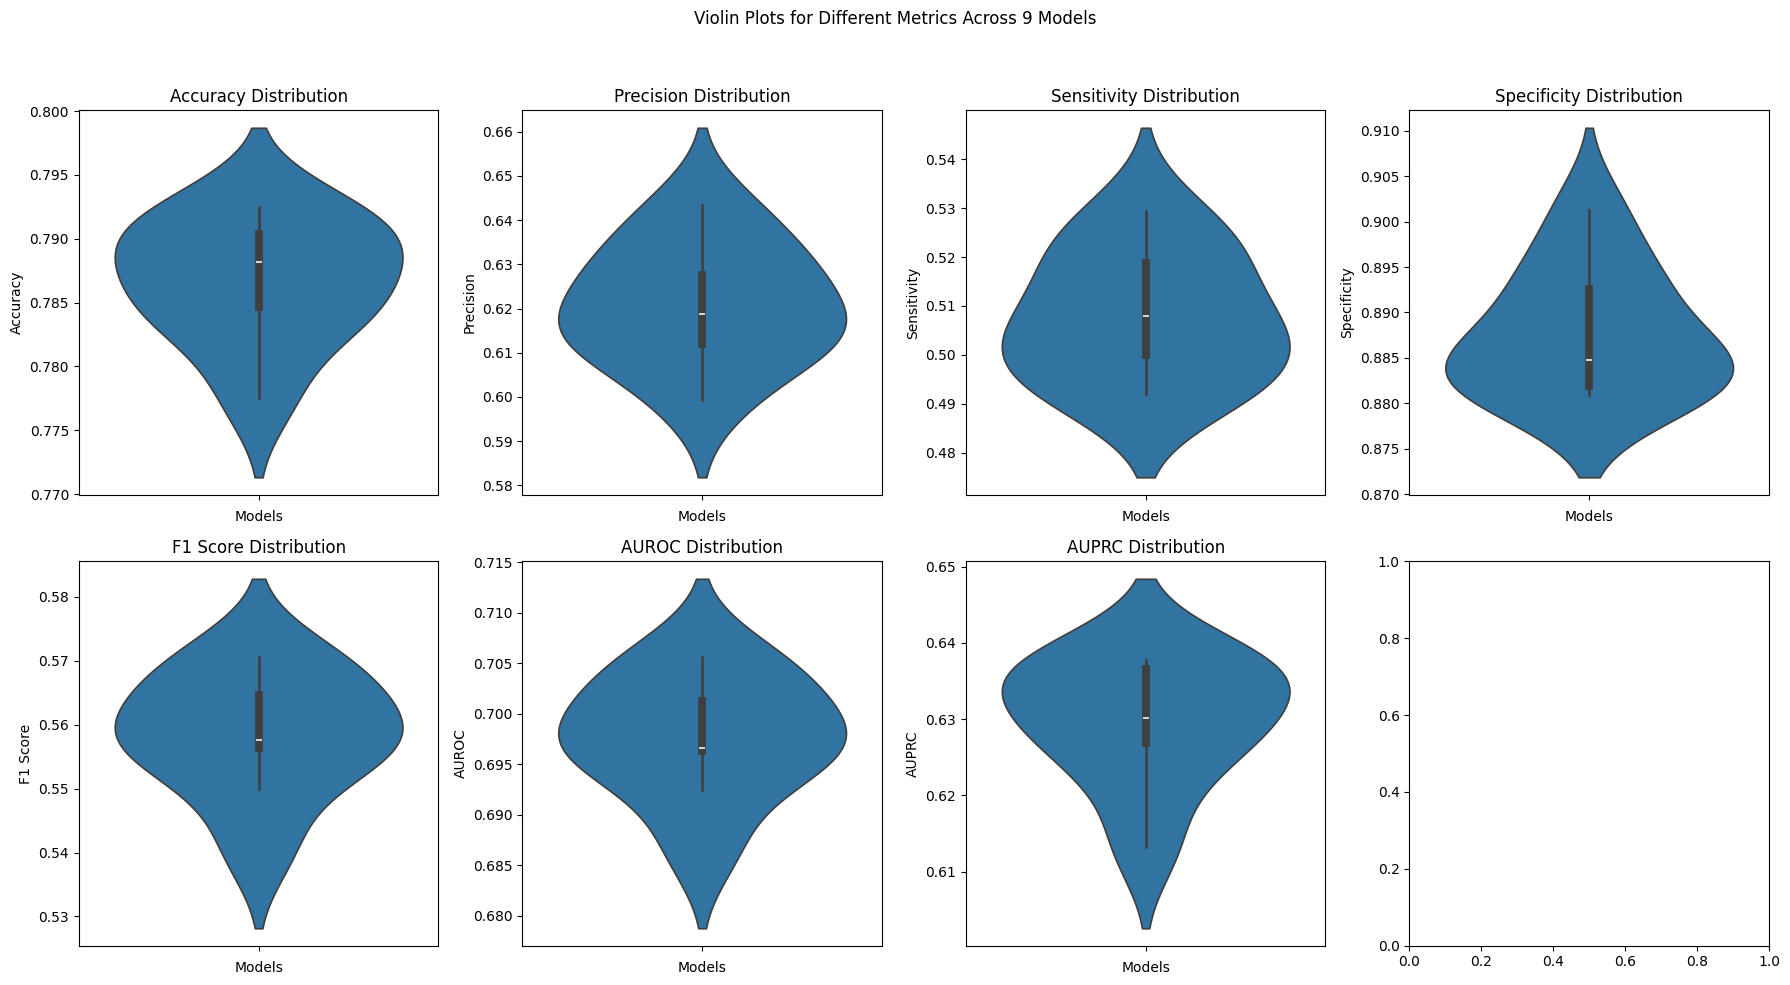

In [71]:
print("Violin Plots for Telco Dataset")
violin_plot(1)

Violin Plots for Adult Dataset


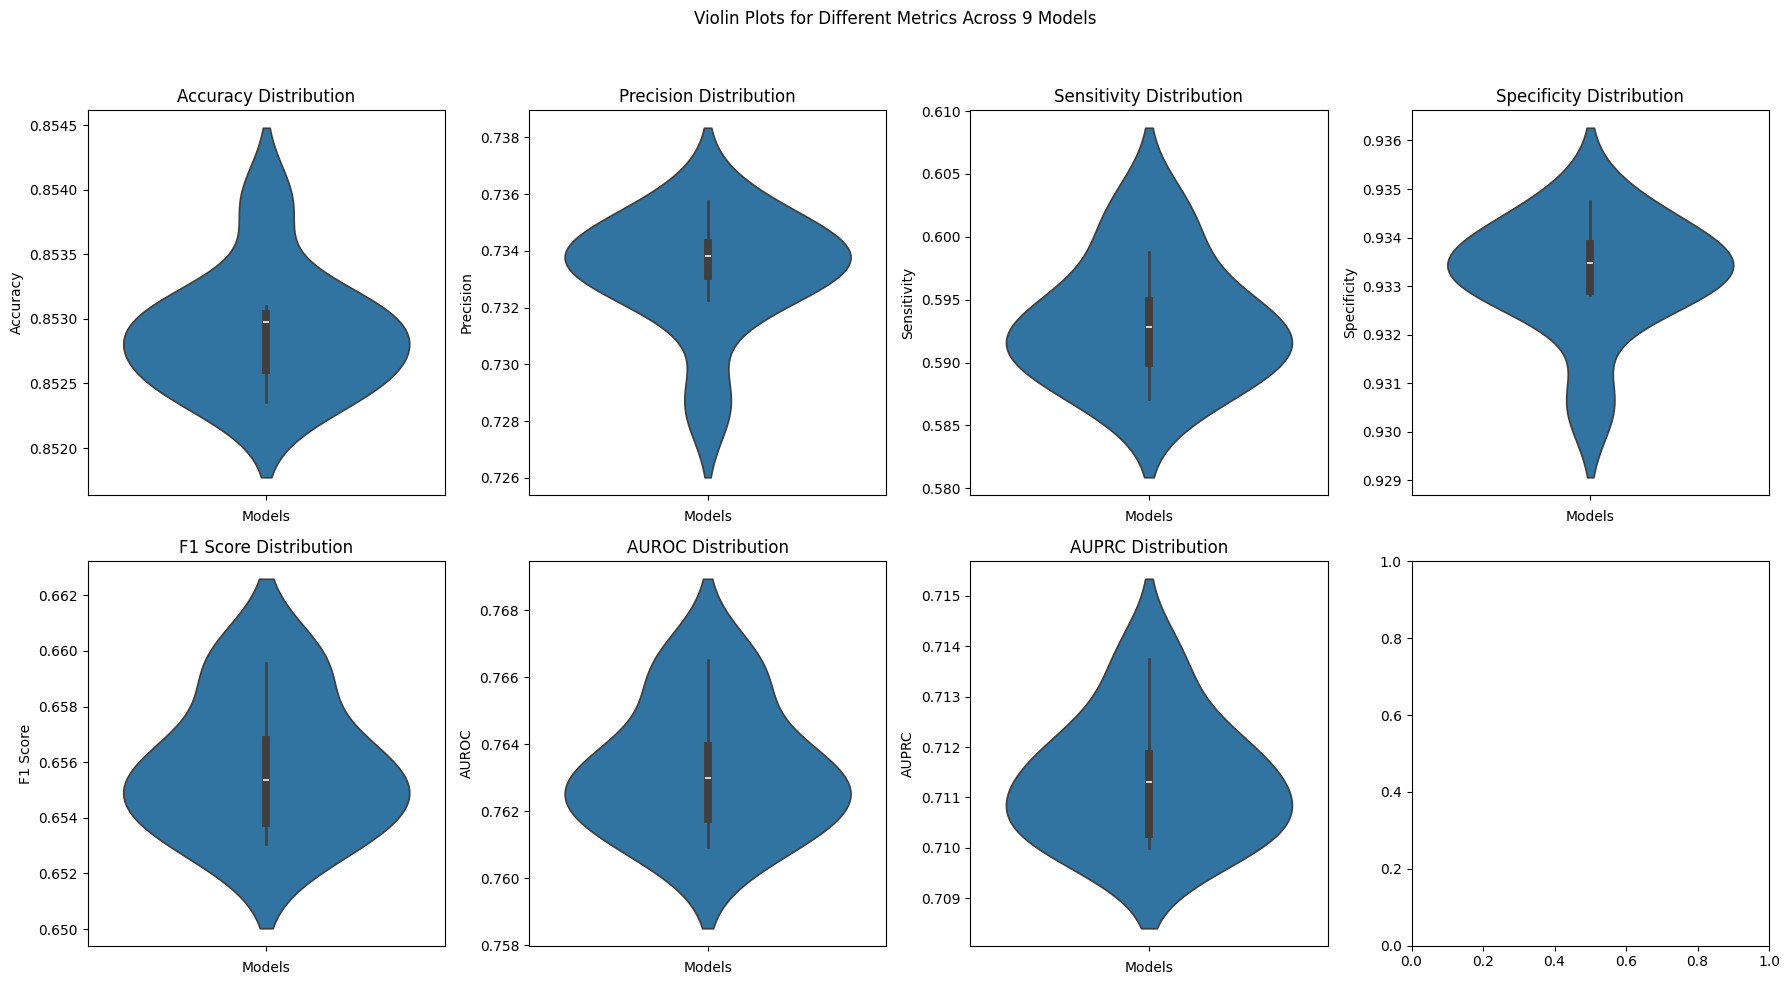

In [72]:
print("Violin Plots for Adult Dataset")
violin_plot(2)

Violin Plots for Credit Card Dataset


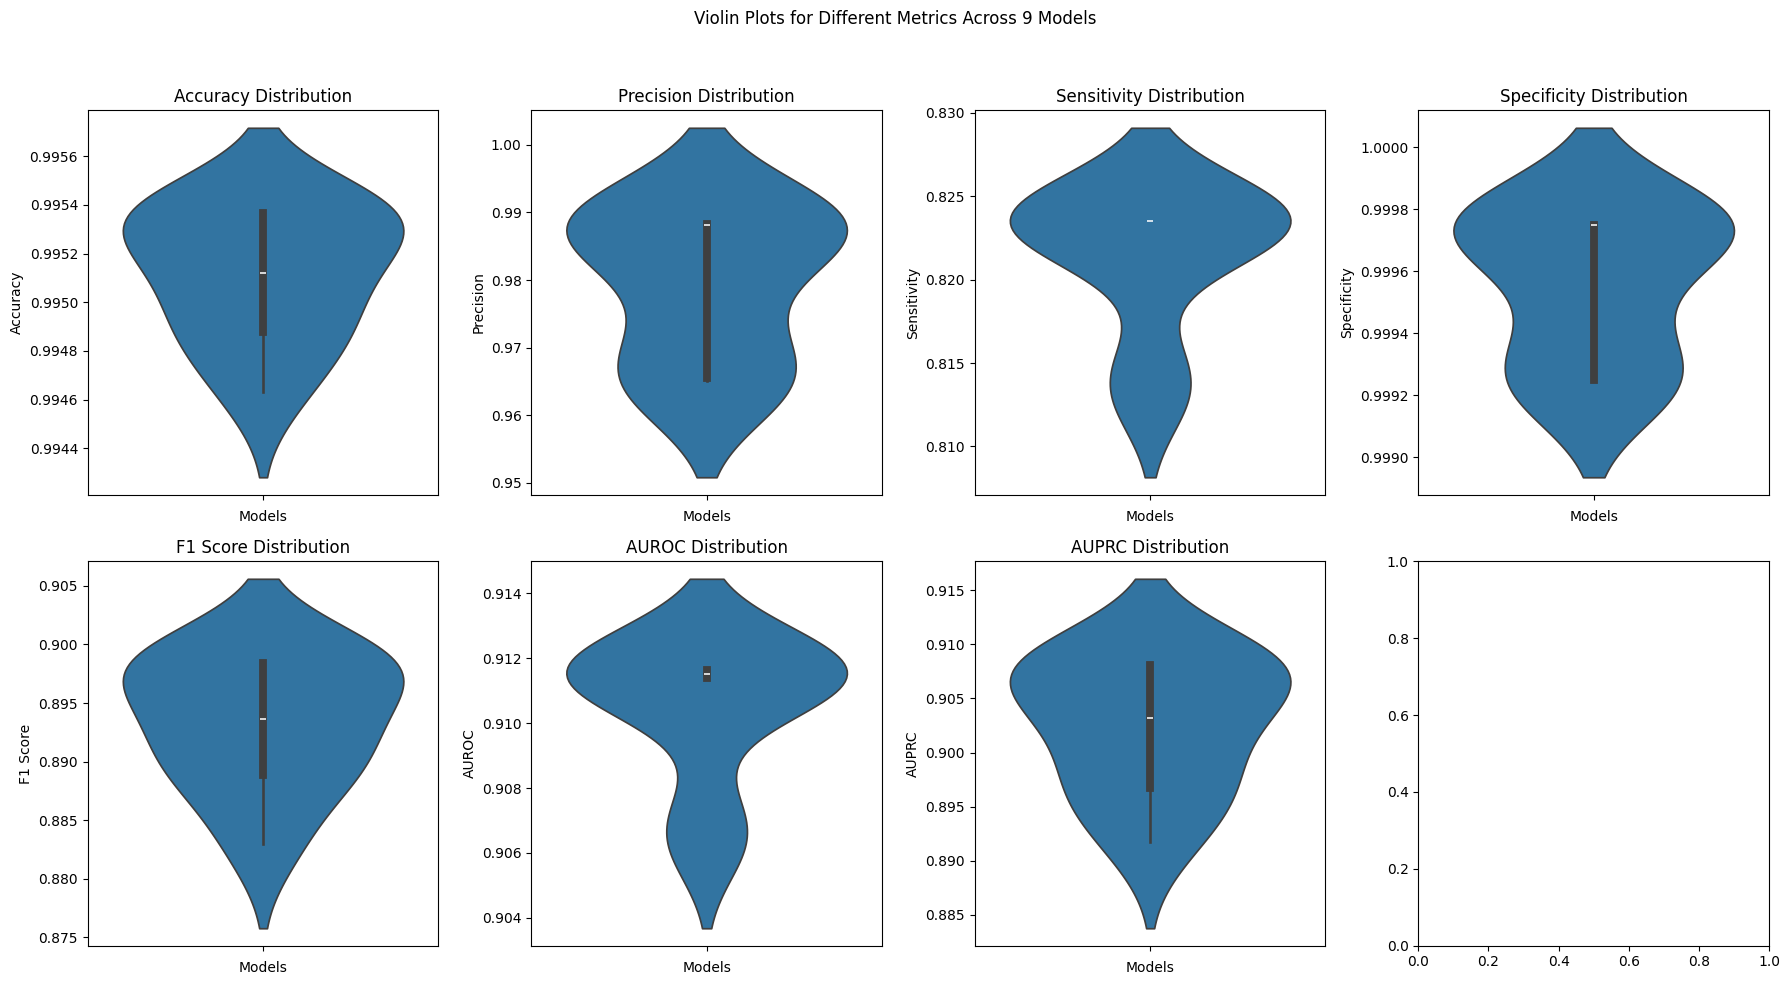

In [74]:
print("Violin Plots for Credit Card Dataset")
violin_plot(3)